In [4]:
pip install jupyter_dash

In [25]:
import pandas as pd
import numpy as np
import dash


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report



from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import download

from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output



In [6]:
#download vader
download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [7]:
# Initialize sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

In [8]:
def wrangle(filepath):
  #read the csv file
  df = pd.read_csv(filepath)

  #set index name as "Index"
  df.set_index(pd.RangeIndex(start = 1, stop = len(df)+1))
  df.index.name = "Index"

  #create column named "Time"
  df['Time'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

  #drop columns
  df.drop(columns = ['Timestamp', 'Month', 'Day', 'Hour', 'Unnamed: 0.1', 'Unnamed: 0', 'Text', 'User', 'Hashtags'], inplace = True)

  #strip spaces to correct the Twitter duplicate problem

  df['Platform'] = df['Platform'].str.strip()
  df['Country'] = df['Country'].str.strip().str.title()
  df['Sentiment'] = df['Sentiment'].str.strip()

  return df


In [9]:
# A function to help classify the sentiments
def classify_sentiment(text):
    score = sia.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

Replace the filepath in the wrangle parameter below

In [10]:
df = wrangle("/content/drive/MyDrive/sentimentdataset.csv")
df['Sentiment'] = df['Sentiment'].apply(classify_sentiment)
df.head()

,Sentiment,Platform,Retweets,Likes,Country,Year,Time
Index,,,,,,,
0,Positive,Twitter,15.0,30.0,Usa,2023,2023-01-15
1,Negative,Twitter,5.0,10.0,Canada,2023,2023-01-15
2,Positive,Instagram,20.0,40.0,Usa,2023,2023-01-15
3,Positive,Facebook,8.0,15.0,Uk,2023,2023-01-15
4,Neutral,Instagram,12.0,25.0,Australia,2023,2023-01-15


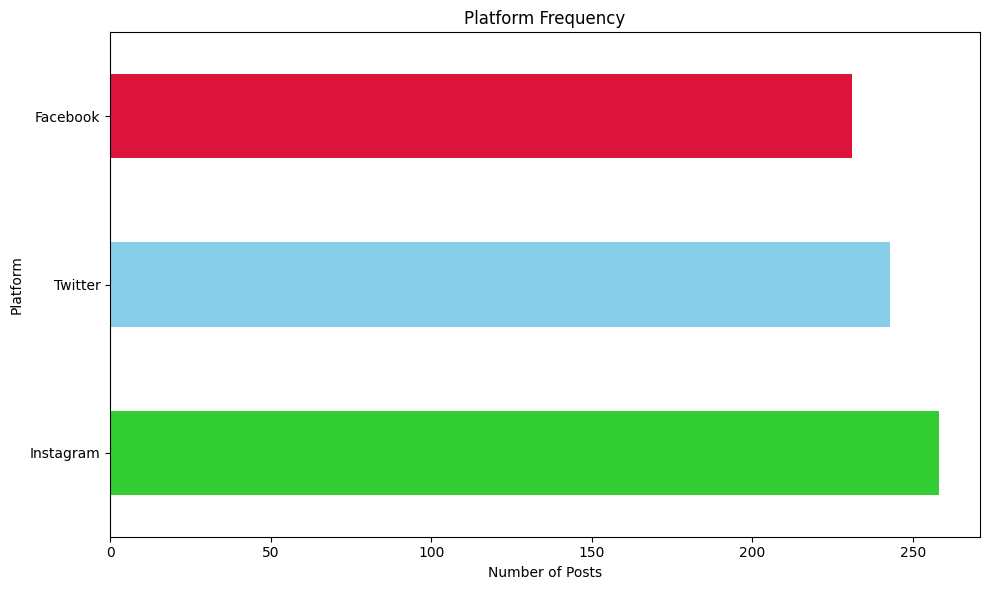

In [11]:
color_map = ['limegreen','skyblue', 'crimson']

fig, ax = plt.subplots(figsize = (10, 6))
df['Platform'].value_counts().plot.barh(ax=ax, color=color_map)
ax.set_title("Platform Frequency")
ax.set_ylabel("Platform")
ax.set_xlabel("Number of Posts")

plt.tight_layout()
plt.show()

As the graph demonstrates, Instagram is the highest used platfrom and Facebook the least.

In [12]:
# Group data: count how many times each platform appears per year
df_grouped = df.groupby(['Year', 'Platform']).size().reset_index(name='Number of Posts')

fig = px.bar(
    data_frame=df_grouped,
    x='Year',
    y='Number of Posts',
    color='Platform',
    title='Platform Usage Throughout the Years',
    barmode='group'
)

# Show every year
fig.update_layout(
    xaxis = dict(
        tickmode='linear',
        dtick=1
    )
)

fig.show()

As It can be noticed, that throughout the years, Instagram and twitter start to dominate the population as we approached the years 2020 up until 2023

In [13]:
df_countries = df.groupby(['Country', 'Platform']).size().reset_index(name='Number of Posts')

fig = px.bar(
    df_countries,
    x='Country',
    y='Number of Posts',
    color='Platform',
    title='Platform Usage by Country',
    barmode='group'
)

# Rotate labels and avoid crowding
fig.update_layout(
    xaxis_tickangle=-60
)


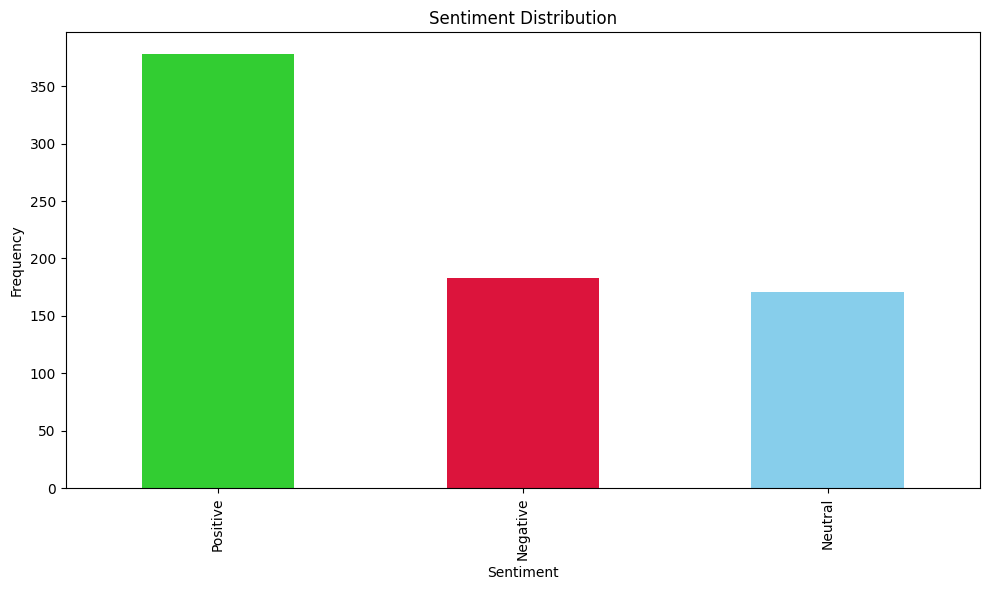

In [14]:
color_map = ['limegreen','crimson', 'skyblue']

fig, ax = plt.subplots(figsize = (10, 6))
df['Sentiment'].value_counts().plot.bar(ax=ax, color=color_map)
ax.set_title("Sentiment Distribution")
ax.set_xlabel("Sentiment")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [15]:
#this is how the Sentiment Intensity Analyzer works
sia.polarity_scores("I hate this movie!")


{'neg': 0.666, 'neu': 0.334, 'pos': 0.0, 'compound': -0.6114}

**MODEL BUILDING**

Preprocessing

In [16]:
# Label encode sentiment
sentiment_encoder = LabelEncoder()
df['Sentiment_encoded'] = sentiment_encoder.fit_transform(df['Sentiment'])
# For visualization
df_viz = df.copy()

# Create modeling dataset
df_model = df.copy()
df_model = pd.get_dummies(df_model, columns=['Platform', 'Country'], drop_first=True)


In [17]:
features = df_model.drop(columns=['Sentiment', 'Time', 'Sentiment_encoded'])
target = df_model['Sentiment_encoded']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target)


In [18]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=sentiment_encoder.classes_))


              precision    recall  f1-score   support

    Negative       0.56      0.51      0.54        37
     Neutral       0.41      0.38      0.39        34
    Positive       0.60      0.64      0.62        76

    accuracy                           0.55       147
   macro avg       0.52      0.51      0.52       147
weighted avg       0.55      0.55      0.55       147



In [19]:
df.head(10)

,Sentiment,Platform,Retweets,Likes,Country,Year,Time,Sentiment_encoded
Index,,,,,,,,
0,Positive,Twitter,15.0,30.0,Usa,2023,2023-01-15,2
1,Negative,Twitter,5.0,10.0,Canada,2023,2023-01-15,0
2,Positive,Instagram,20.0,40.0,Usa,2023,2023-01-15,2
3,Positive,Facebook,8.0,15.0,Uk,2023,2023-01-15,2
4,Neutral,Instagram,12.0,25.0,Australia,2023,2023-01-15,1
5,Positive,Twitter,25.0,50.0,India,2023,2023-01-16,2
6,Positive,Facebook,10.0,20.0,Canada,2023,2023-01-16,2
7,Positive,Instagram,15.0,30.0,Usa,2023,2023-01-16,2
8,Negative,Twitter,30.0,60.0,Usa,2023,2023-01-17,0


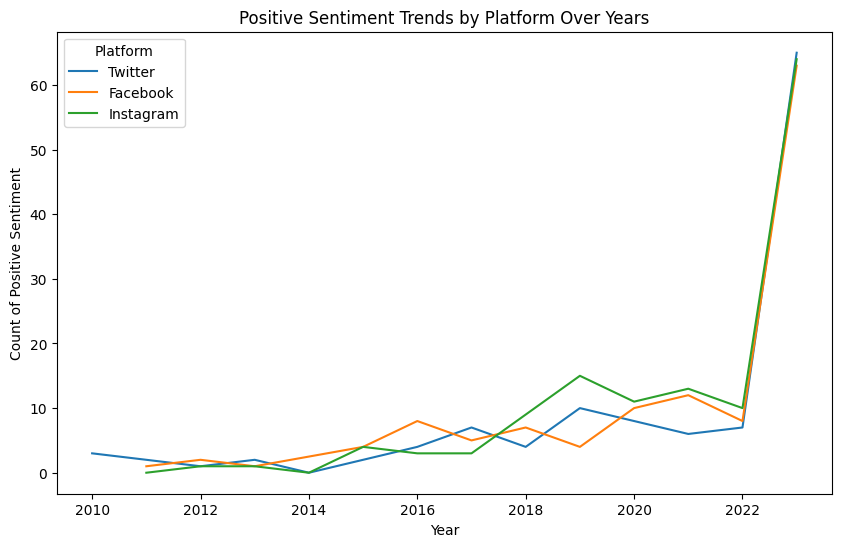

In [20]:
df_viz['Sentiment_encoded'] = LabelEncoder().fit_transform(df_viz['Sentiment'])

# Group for plotting
platform_year_sentiment = df_viz.groupby(['Year', 'Platform'])['Sentiment'].value_counts().unstack().fillna(0).reset_index()

# Plotting trend of Positive sentiment
plt.figure(figsize=(10, 6))
sns.lineplot(data=platform_year_sentiment, x='Year', y='Positive', hue='Platform')
plt.title("Positive Sentiment Trends by Platform Over Years")
plt.ylabel("Count of Positive Sentiment")
plt.show()

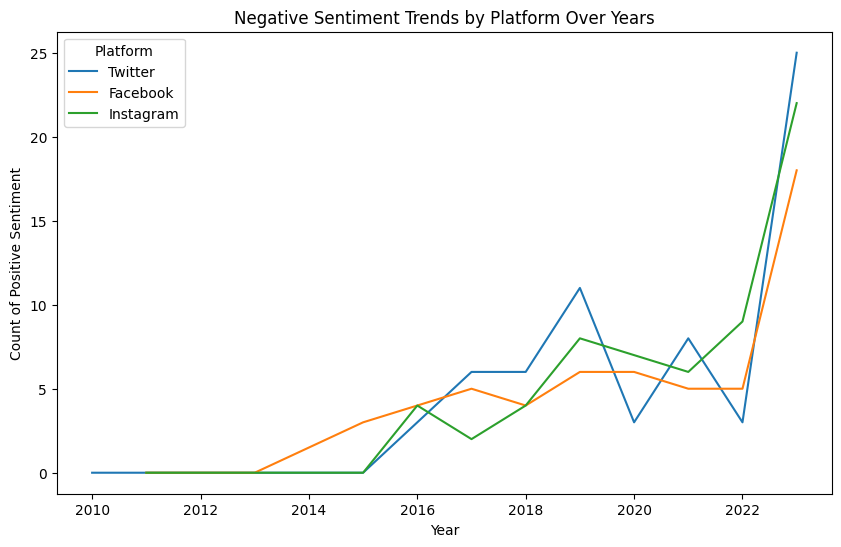

In [21]:
df_viz['Sentiment_encoded'] = LabelEncoder().fit_transform(df_viz['Sentiment'])

# Group for plotting
platform_year_sentiment = df_viz.groupby(['Year', 'Platform'])['Sentiment'].value_counts().unstack().fillna(0).reset_index()

# Plotting trend of Positive sentiment
plt.figure(figsize=(10, 6))
sns.lineplot(data=platform_year_sentiment, x='Year', y='Negative', hue='Platform')
plt.title("Negative Sentiment Trends by Platform Over Years")
plt.ylabel("Count of Positive Sentiment")
plt.show()

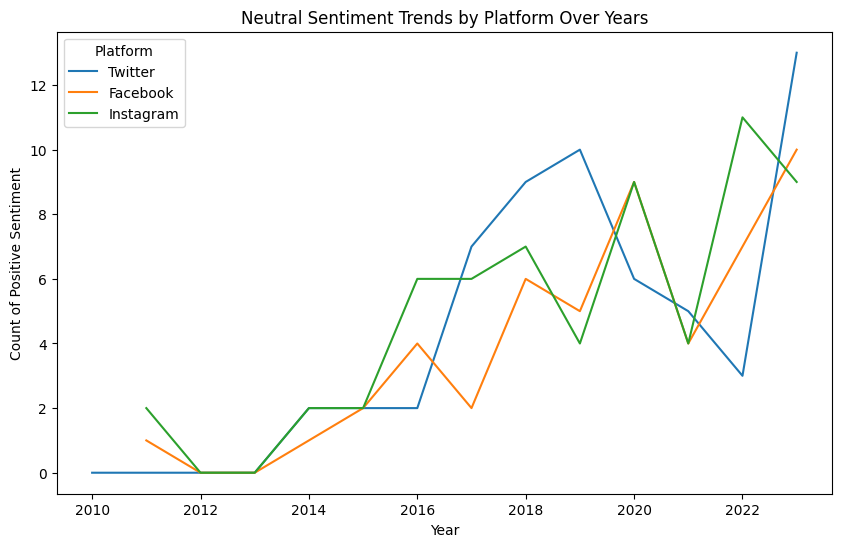

In [22]:
df_viz['Sentiment_encoded'] = LabelEncoder().fit_transform(df_viz['Sentiment'])

# Group for plotting
platform_year_sentiment = df_viz.groupby(['Year', 'Platform'])['Sentiment'].value_counts().unstack().fillna(0).reset_index()

# Plotting trend of Positive sentiment
plt.figure(figsize=(10, 6))
sns.lineplot(data=platform_year_sentiment, x='Year', y='Neutral', hue='Platform')
plt.title("Neutral Sentiment Trends by Platform Over Years")
plt.ylabel("Count of Positive Sentiment")
plt.show()

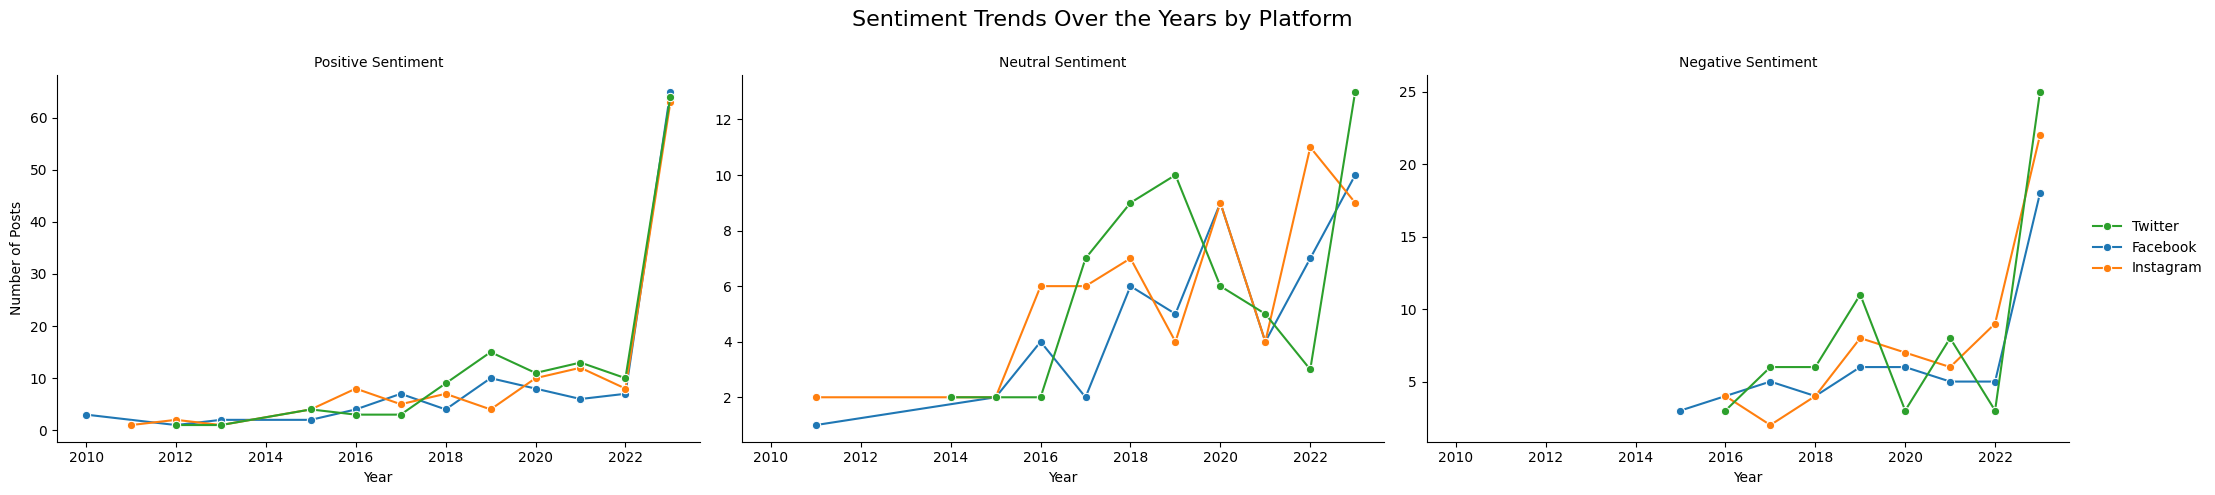

In [23]:
# Group and count sentiments per year and platform
grouped = df_viz.groupby(['Year', 'Platform', 'Sentiment']).size().reset_index(name='Count')

# Create a FacetGrid for multiple plots by sentiment
g = sns.FacetGrid(grouped, col="Sentiment", height=5, aspect=1.4, sharey=False)
g.map_dataframe(sns.lineplot, x="Year", y="Count", hue="Platform", marker='o')
g.add_legend()

# for greater readability
g.set_titles("{col_name} Sentiment")
g.set_axis_labels("Year", "Number of Posts")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Sentiment Trends Over the Years by Platform", fontsize=16)

plt.show()

Notice how negative sentiment from users started in the year between 2014 and 2016. You could probably conclude that people started to use platfroms to express bad things going on their lives or express negative expressions toward other things.



Over the years, Twitter now X seems to be the platform that is overly used or will continue to be, with all different sentiments remarked in their tweets.


Although this doesn't express or conclude completely, there is a decline in the usage of Facebook by a certain number of people based on the number of posts across these platforms.

In [26]:
# Initialize app
app = dash.Dash(__name__)
server = app.server

In [27]:
app.layout = html.Div([
    html.H2("Sentiment Trend Analysis by Platform"),

    html.Label("Select Sentiment:"),
    dcc.Dropdown(
        id='sentiment-selector',
        options=[{'label': s, 'value': s} for s in df['Sentiment'].unique()],
        value='Positive',
        clearable=False
    ),

    dcc.Graph(id='trend-graph')
])

In [28]:
# Callback
@app.callback(
    Output('trend-graph', 'figure'),
    Input('sentiment-selector', 'value')
)
def update_graph(selected_sentiment):
    dff = df[df['Sentiment'] == selected_sentiment]
    dfg = dff.groupby(['Year', 'Platform']).size().reset_index(name='Count')
    fig = px.line(dfg, x='Year', y='Count', color='Platform', markers=True,
                  title=f"{selected_sentiment} Sentiment Trend by Platform")
    return fig

In [30]:
# Run app
if __name__ == '__main__':
    app.run(debug=True)

<IPython.core.display.Javascript object>